Generating 50,000 samples...

SQUEEZE REJECTION SAMPLING RESULTS

Total proposals made: 65,609
Total samples generated: 50,000
π~ evaluations: 27,871

----------------------------------------
PROBABILITY OF NOT EVALUATING π~
----------------------------------------
Empirical probability: 0.5752
Theoretical probability: 0.5718
Difference: 0.0034

----------------------------------------
ACCEPTANCE RATES
----------------------------------------
Step (b) acceptance rate: 0.5752
Step (c) acceptance rate: 0.1869
Overall acceptance rate: 0.7621
Theoretical acceptance rate: 0.6065


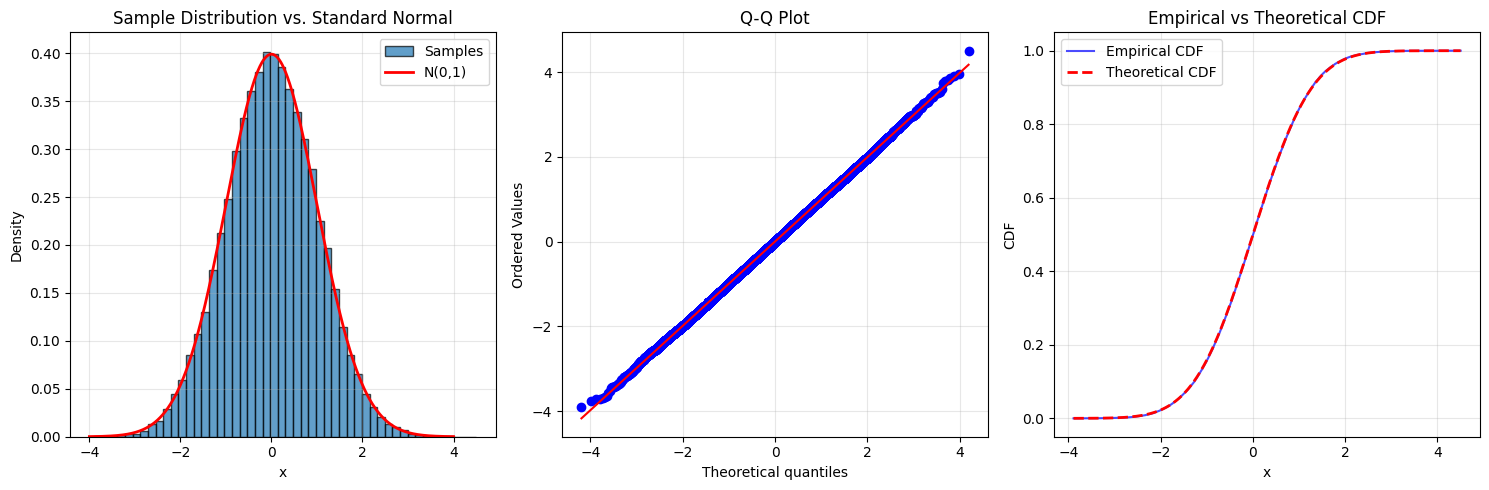


----------------------------------------
STATISTICAL TESTS
----------------------------------------
Kolmogorov-Smirnov test: statistic=0.0032, p-value=0.6715

Sample mean: 0.0036 (theoretical: 0.0000)
Sample std: 0.9948 (theoretical: 1.0000)
Sample skewness: 0.0033 (theoretical: 0.0000)
Sample kurtosis: -0.0232 (theoretical: 0.0000)

CONSISTENCY CHECK (10 independent runs)
Run  1: P(not eval) = 0.5752, Accept rate = 0.7623
Run  2: P(not eval) = 0.5699, Accept rate = 0.7586
Run  3: P(not eval) = 0.5703, Accept rate = 0.7551
Run  4: P(not eval) = 0.5678, Accept rate = 0.7541
Run  5: P(not eval) = 0.5731, Accept rate = 0.7626
Run  6: P(not eval) = 0.5799, Accept rate = 0.7672
Run  7: P(not eval) = 0.5753, Accept rate = 0.7670
Run  8: P(not eval) = 0.5712, Accept rate = 0.7603
Run  9: P(not eval) = 0.5757, Accept rate = 0.7656
Run 10: P(not eval) = 0.5716, Accept rate = 0.7596

Probability of not evaluating π~:
  Mean: 0.5730
  Std dev: 0.0034
  Min: 0.5678, Max: 0.5799
  Theoretical: 0.5

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as scipy_stats
from scipy.stats import laplace


class SqueezeRejectionSampler:
    """
    Implements squeeze rejection sampling for sampling from standard normal
    using Laplace distribution as proposal.
    """

    def __init__(self):
        # M = sqrt(e) as calculated in the solution
        self.M = np.sqrt(np.e)
        self.pi_tilde_evals = 0  # Counter for expensive evaluations
        self.total_proposals = 0  # Total number of proposals
        self.step_b_accepts = 0  # Accepts in step (b)
        self.step_c_accepts = 0  # Accepts in step (c)

    def h(self, x):
        """Lower bound function: h(x) = max(0, 1 - x^2/2)"""
        result = 1 - x**2 / 2
        return np.maximum(0, result)

    def pi_tilde(self, x):
        """Target unnormalized density: exp(-x^2/2)"""
        self.pi_tilde_evals += 1
        return np.exp(-(x**2) / 2)

    def q_tilde(self, x):
        """Proposal unnormalized density: exp(-|x|)"""
        return np.exp(-np.abs(x))

    def sample_laplace(self):
        """Sample from Laplace(0, 1) distribution"""
        return laplace.rvs(size=1)

    def sample_one(self):
        """Generate one sample using squeeze rejection algorithm (optimized)"""
        M = self.M  # Cache attribute locally

        while True:
            self.total_proposals += 1

            # Step (a): Draw X ~ q, U ~ U[0,1]
            x = laplace.rvs()  # Return scalar directly
            u = np.random.uniform()

            # Compute shared values once
            x_sq_half = x * x * 0.5  # Cache x²/2
            q_tilde_x = np.exp(-abs(x))

            # Step (b): Check if U <= h(X)/(M*q_tilde(X))
            h_x = max(0.0, 1.0 - x_sq_half)  # Use Python max for scalars

            if h_x > 0.0 and u <= h_x / (M * q_tilde_x):
                self.step_b_accepts += 1
                return x

            # Step (c): Need to evaluate pi_tilde
            v = np.random.uniform()
            self.pi_tilde_evals += 1
            pi_tilde_x = np.exp(-x_sq_half)  # Reuse cached x²/2

            if v <= (pi_tilde_x - h_x) / (M * q_tilde_x - h_x):
                self.step_c_accepts += 1
                return x

    def sample(self, n):
        """Generate n samples"""
        samples = np.array([self.sample_one() for _ in range(n)])
        return samples

    def get_statistics(self):
        """Return sampling statistics"""
        if self.total_proposals == 0:
            return {}

        prob_not_eval = 1 - (self.pi_tilde_evals / self.total_proposals)
        prob_accept_b = self.step_b_accepts / self.total_proposals
        prob_accept_c = self.step_c_accepts / self.total_proposals
        acceptance_rate = (
            self.step_b_accepts + self.step_c_accepts
        ) / self.total_proposals

        return {
            "total_proposals": self.total_proposals,
            "pi_tilde_evaluations": self.pi_tilde_evals,
            "step_b_accepts": self.step_b_accepts,
            "step_c_accepts": self.step_c_accepts,
            "prob_not_evaluating_pi": prob_not_eval,
            "prob_accept_step_b": prob_accept_b,
            "prob_accept_step_c": prob_accept_c,
            "overall_acceptance_rate": acceptance_rate,
            "theoretical_prob_not_eval": 2 * np.sqrt(2) / (3 * np.sqrt(np.e)),
        }


def verify_implementation(n_samples=50000, show_plots=True):
    """Verify the implementation with empirical results"""

    # Initialize sampler
    sampler = SqueezeRejectionSampler()

    # Generate samples
    print(f"Generating {n_samples:,} samples...")
    samples = sampler.sample(n_samples)

    # Get statistics
    sampling_stats = sampler.get_statistics()

    print("\n" + "=" * 60)
    print("SQUEEZE REJECTION SAMPLING RESULTS")
    print("=" * 60)

    print(f"\nTotal proposals made: {sampling_stats['total_proposals']:,}")
    print(f"Total samples generated: {n_samples:,}")
    print(f"π~ evaluations: {sampling_stats['pi_tilde_evaluations']:,}")

    print("\n" + "-" * 40)
    print("PROBABILITY OF NOT EVALUATING π~")
    print("-" * 40)
    print(f"Empirical probability: {sampling_stats['prob_not_evaluating_pi']:.4f}")
    print(f"Theoretical probability: {sampling_stats['theoretical_prob_not_eval']:.4f}")
    print(
        f"Difference: {abs(sampling_stats['prob_not_evaluating_pi'] - sampling_stats['theoretical_prob_not_eval']):.4f}"
    )

    print("\n" + "-" * 40)
    print("ACCEPTANCE RATES")
    print("-" * 40)
    print(f"Step (b) acceptance rate: {sampling_stats['prob_accept_step_b']:.4f}")
    print(f"Step (c) acceptance rate: {sampling_stats['prob_accept_step_c']:.4f}")
    print(f"Overall acceptance rate: {sampling_stats['overall_acceptance_rate']:.4f}")
    print(f"Theoretical acceptance rate: {1 / sampler.M:.4f}")

    if show_plots:
        # Visual verification
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot 1: Histogram with theoretical density
        ax1 = axes[0]
        ax1.hist(
            samples,
            bins=50,
            density=True,
            alpha=0.7,
            edgecolor="black",
            label="Samples",
        )
        x_range = np.linspace(-4, 4, 1000)
        ax1.plot(x_range, scipy_stats.norm.pdf(x_range), "r-", lw=2, label="N(0,1)")
        ax1.set_xlabel("x")
        ax1.set_ylabel("Density")
        ax1.set_title("Sample Distribution vs. Standard Normal")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Q-Q plot
        ax2 = axes[1]
        scipy_stats.probplot(samples, dist="norm", plot=ax2)
        ax2.set_title("Q-Q Plot")
        ax2.grid(True, alpha=0.3)

        # Plot 3: Empirical CDF vs theoretical CDF
        ax3 = axes[2]
        sorted_samples = np.sort(samples)
        empirical_cdf = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
        theoretical_cdf = scipy_stats.norm.cdf(sorted_samples)
        ax3.plot(sorted_samples, empirical_cdf, "b-", alpha=0.7, label="Empirical CDF")
        ax3.plot(sorted_samples, theoretical_cdf, "r--", lw=2, label="Theoretical CDF")
        ax3.set_xlabel("x")
        ax3.set_ylabel("CDF")
        ax3.set_title("Empirical vs Theoretical CDF")
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Statistical tests
    print("\n" + "-" * 40)
    print("STATISTICAL TESTS")
    print("-" * 40)

    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = scipy_stats.kstest(samples, "norm")
    print(f"Kolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

    # Sample moments
    print(f"\nSample mean: {np.mean(samples):.4f} (theoretical: 0.0000)")
    print(f"Sample std: {np.std(samples, ddof=1):.4f} (theoretical: 1.0000)")
    print(f"Sample skewness: {scipy_stats.skew(samples):.4f} (theoretical: 0.0000)")
    print(f"Sample kurtosis: {scipy_stats.kurtosis(samples):.4f} (theoretical: 0.0000)")

    return samples, sampling_stats


def run_consistency_check(n_runs=10, samples_per_run=10000):
    """Run multiple independent trials to check consistency"""
    print("\n" + "=" * 60)
    print(f"CONSISTENCY CHECK ({n_runs} independent runs)")
    print("=" * 60)

    prob_not_eval_list = []
    acceptance_rates = []

    for i in range(n_runs):
        sampler = SqueezeRejectionSampler()
        _ = sampler.sample(samples_per_run)
        test_stats = sampler.get_statistics()
        prob_not_eval_list.append(test_stats["prob_not_evaluating_pi"])
        acceptance_rates.append(test_stats["overall_acceptance_rate"])
        print(
            f"Run {i + 1:2d}: P(not eval) = {test_stats['prob_not_evaluating_pi']:.4f}, "
            f"Accept rate = {test_stats['overall_acceptance_rate']:.4f}"
        )

    theoretical_prob = 2 * np.sqrt(2) / (3 * np.sqrt(np.e))

    print("\nProbability of not evaluating π~:")
    print(f"  Mean: {np.mean(prob_not_eval_list):.4f}")
    print(f"  Std dev: {np.std(prob_not_eval_list):.4f}")
    print(
        f"  Min: {np.min(prob_not_eval_list):.4f}, Max: {np.max(prob_not_eval_list):.4f}"
    )
    print(f"  Theoretical: {theoretical_prob:.4f}")

    print("\nAcceptance rate:")
    print(f"  Mean: {np.mean(acceptance_rates):.4f}")
    print(f"  Theoretical: {1 / np.sqrt(np.e):.4f}")


# Run the verification
if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility

    # Main verification
    samples, sampling_statistics = verify_implementation(
        n_samples=50000, show_plots=True
    )

    # Consistency check
    run_consistency_check(n_runs=10, samples_per_run=10000)

In [2]:
class SqueezeRejectionSampler2:
    """
    Vectorized squeeze rejection sampler with adaptive batching.
    Efficiently generates exactly n samples by predicting batch sizes.
    """

    def __init__(self):
        # M = sqrt(e) as calculated in the solution
        self.M = np.sqrt(np.e)
        self.pi_tilde_evals = 0  # Counter for expensive evaluations
        self.total_proposals = 0  # Total number of proposals
        self.step_b_accepts = 0  # Accepts in step (b)
        self.step_c_accepts = 0  # Accepts in step (c)

        # Adaptive batching parameters
        self.theoretical_accept_rate = 1 / self.M  # ~0.6065
        self.current_accept_rate = self.theoretical_accept_rate
        self.min_batch_size = 100
        self.max_batch_size = 50000

    def _estimate_batch_size(self, samples_needed):
        """Estimate batch size based on current acceptance rate"""
        if samples_needed <= 0:
            return 0

        # Add 20% buffer to account for variance
        estimated_batch = int(samples_needed / self.current_accept_rate * 1.2)
        return max(self.min_batch_size, min(estimated_batch, self.max_batch_size))

    def _vectorized_sample_batch(self, batch_size):
        """Generate a batch of samples using vectorized operations"""
        self.total_proposals += batch_size

        # Step (a): Draw X ~ Laplace, U ~ U[0,1] vectorized
        x = laplace.rvs(size=batch_size)
        u = np.random.uniform(size=batch_size)

        # Vectorized computations
        x_sq_half = x * x * 0.5
        q_tilde_x = np.exp(-np.abs(x))
        h_x = np.maximum(0.0, 1.0 - x_sq_half)

        # Step (b): Vectorized acceptance check
        step_b_ratio = h_x / (self.M * q_tilde_x)
        step_b_accept = (h_x > 0) & (u <= step_b_ratio)

        # Count step (b) accepts
        step_b_count = np.sum(step_b_accept)
        self.step_b_accepts += step_b_count

        # For samples not accepted in step (b), try step (c)
        step_b_reject_mask = ~step_b_accept
        step_c_candidates = np.sum(step_b_reject_mask)

        if step_c_candidates > 0:
            # Step (c): Generate new uniforms only for rejected samples
            v = np.random.uniform(size=step_c_candidates)

            # Get values for rejected samples
            x_sq_half_reject = x_sq_half[step_b_reject_mask]
            h_x_reject = h_x[step_b_reject_mask]
            q_tilde_x_reject = q_tilde_x[step_b_reject_mask]

            # Evaluate pi_tilde only for step (c) candidates
            self.pi_tilde_evals += step_c_candidates
            pi_tilde_x_reject = np.exp(-x_sq_half_reject)

            # Step (c) acceptance check
            denominator = self.M * q_tilde_x_reject - h_x_reject
            step_c_accept_local = (denominator > 0) & (
                v <= (pi_tilde_x_reject - h_x_reject) / denominator
            )

            # Count step (c) accepts
            step_c_count = np.sum(step_c_accept_local)
            self.step_c_accepts += step_c_count

            # Combine accepts: step (b) accepts + step (c) accepts
            all_accepts = np.zeros(batch_size, dtype=bool)
            all_accepts[step_b_accept] = True
            all_accepts[step_b_reject_mask] = step_c_accept_local
        else:
            all_accepts = step_b_accept

        return x[all_accepts]

    def sample(self, n):
        """Generate exactly n samples using adaptive vectorized batching"""
        if n <= 0:
            return np.array([])

        samples = []
        samples_collected = 0

        while samples_collected < n:
            samples_needed = n - samples_collected
            batch_size = self._estimate_batch_size(samples_needed)

            # Generate batch
            batch_samples = self._vectorized_sample_batch(batch_size)
            batch_accepted = len(batch_samples)

            # Update acceptance rate estimate (exponential moving average)
            if batch_size > 0:
                batch_accept_rate = batch_accepted / batch_size
                alpha = 0.1  # Learning rate
                self.current_accept_rate = (
                    1 - alpha
                ) * self.current_accept_rate + alpha * batch_accept_rate

            # Take only what we need
            samples_to_take = min(batch_accepted, samples_needed)
            if samples_to_take > 0:
                samples.append(batch_samples[:samples_to_take])
                samples_collected += samples_to_take

        return np.concatenate(samples)

    def sample_one(self):
        """Generate one sample (for compatibility)"""
        return self.sample(1)[0]

    def get_statistics(self):
        """Return sampling statistics"""
        if self.total_proposals == 0:
            return {}

        prob_not_eval = 1 - (self.pi_tilde_evals / self.total_proposals)
        prob_accept_b = self.step_b_accepts / self.total_proposals
        prob_accept_c = self.step_c_accepts / self.total_proposals
        acceptance_rate = (
            self.step_b_accepts + self.step_c_accepts
        ) / self.total_proposals

        return {
            "total_proposals": self.total_proposals,
            "pi_tilde_evaluations": self.pi_tilde_evals,
            "step_b_accepts": self.step_b_accepts,
            "step_c_accepts": self.step_c_accepts,
            "prob_not_evaluating_pi": prob_not_eval,
            "prob_accept_step_b": prob_accept_b,
            "prob_accept_step_c": prob_accept_c,
            "overall_acceptance_rate": acceptance_rate,
            "theoretical_prob_not_eval": 2 * np.sqrt(2) / (3 * np.sqrt(np.e)),
            "current_accept_rate_estimate": self.current_accept_rate,
        }

In [3]:
class SqueezeRejectionSampler3:
    """
    Generic vectorized squeeze rejection sampler with adaptive batching.
    Takes distributions and functions as arguments for maximum flexibility.
    """

    def __init__(
        self,
        target_logpdf,
        proposal_dist,
        squeeze_func,
        M,
        min_batch_factor=1.1,
        max_batch_factor=10.0,
    ):
        """
        Parameters:
        -----------
        target_logpdf : callable
            Log probability density function of target distribution
        proposal_dist : rv_continuous
            Proposal distribution (scipy.stats distribution)
        squeeze_func : callable
            Squeeze function h(x) that lower bounds target/proposal
        M : float
            Upper bound constant for rejection sampling
        min_batch_factor : float
            Minimum batch size multiplier (default 1.1)
        max_batch_factor : float
            Maximum batch size multiplier (default 10.0)
        """
        self.target_logpdf = target_logpdf
        self.proposal_dist = proposal_dist
        self.squeeze_func = squeeze_func
        self.M = M
        self.min_batch_factor = min_batch_factor
        self.max_batch_factor = max_batch_factor

        # Adaptive parameters
        self.theoretical_accept_rate = 1.0 / M
        self.current_accept_rate = self.theoretical_accept_rate
        self.learning_rate = 0.15

    def _estimate_batch_size(self, samples_needed):
        """Estimate optimal batch size based on current acceptance rate"""
        if samples_needed <= 0:
            return 0

        # Adaptive batch sizing with bounds
        base_batch = samples_needed / self.current_accept_rate
        min_batch = int(base_batch * self.min_batch_factor)
        max_batch = int(base_batch * self.max_batch_factor)

        # Clamp to reasonable bounds
        return max(min_batch, min(max_batch, 100000))

    def _vectorized_squeeze_rejection(self, batch_size):
        """Vectorized squeeze rejection for one batch"""
        # Step 1: Generate proposals and uniforms
        x = self.proposal_dist.rvs(size=batch_size)
        u = np.random.uniform(size=batch_size)

        # Step 2: Compute squeeze function (vectorized)
        h_x = self.squeeze_func(x)

        # Step 3: Compute proposal density (vectorized log then exp for stability)
        log_q_x = self.proposal_dist.logpdf(x)
        q_x = np.exp(log_q_x)

        # Step 4: Squeeze acceptance test
        squeeze_ratio = h_x / (self.M * q_x)
        squeeze_accept = (h_x > 0) & (u <= squeeze_ratio)

        # Step 5: For non-squeeze accepts, do full rejection test
        non_squeeze_mask = ~squeeze_accept
        n_non_squeeze = np.sum(non_squeeze_mask)

        if n_non_squeeze > 0:
            # Generate new uniforms for non-squeeze samples
            v = np.random.uniform(size=n_non_squeeze)

            # Extract non-squeeze samples
            x_non_squeeze = x[non_squeeze_mask]
            h_x_non_squeeze = h_x[non_squeeze_mask]
            q_x_non_squeeze = q_x[non_squeeze_mask]

            # Evaluate target density (vectorized)
            log_pi_x = self.target_logpdf(x_non_squeeze)
            pi_x = np.exp(log_pi_x)

            # Full rejection test
            denominator = self.M * q_x_non_squeeze - h_x_non_squeeze
            full_accept = (denominator > 0) & (
                v <= (pi_x - h_x_non_squeeze) / denominator
            )

            # Combine all accepts
            all_accepts = np.zeros(batch_size, dtype=bool)
            all_accepts[squeeze_accept] = True
            all_accepts[non_squeeze_mask] = full_accept
        else:
            all_accepts = squeeze_accept

        return x[all_accepts]

    def sample(self, n):
        """Generate exactly n samples using adaptive vectorized squeeze rejection"""
        if n <= 0:
            return np.array([])

        samples = []
        samples_collected = 0
        iteration = 0

        while samples_collected < n:
            samples_needed = n - samples_collected
            batch_size = self._estimate_batch_size(samples_needed)

            # Generate batch
            batch_samples = self._vectorized_squeeze_rejection(batch_size)
            batch_accepted = len(batch_samples)

            # Update acceptance rate estimate (exponential moving average)
            if batch_size > 0:
                batch_accept_rate = batch_accepted / batch_size
                self.current_accept_rate = (
                    1 - self.learning_rate
                ) * self.current_accept_rate + self.learning_rate * batch_accept_rate

            # Take only what we need
            samples_to_take = min(batch_accepted, samples_needed)
            if samples_to_take > 0:
                samples.append(batch_samples[:samples_to_take])
                samples_collected += samples_to_take

            iteration += 1
            # Safety check to prevent infinite loops
            if iteration > 1000:
                break

        return np.concatenate(samples) if samples else np.array([])

    def sample_one(self):
        """Generate one sample"""
        return self.sample(1)[0]


# Factory function for standard normal sampling
def create_normal_squeeze_sampler():
    """Create a SqueezeRejectionSampler3 configured for standard normal sampling"""

    # Target: standard normal log-pdf
    def target_logpdf(x):
        return -0.5 * x**2

    # Proposal: Laplace distribution
    proposal_dist = laplace(loc=0, scale=1)

    # Squeeze function: h(x) = max(0, 1 - x²/2)
    def squeeze_func(x):
        return np.maximum(0.0, 1.0 - 0.5 * x**2)

    # Upper bound constant
    M = np.sqrt(np.e)

    return SqueezeRejectionSampler3(
        target_logpdf=target_logpdf,
        proposal_dist=proposal_dist,
        squeeze_func=squeeze_func,
        M=M,
    )